# Measurement Memory
In the optimization of the flight path, we need to compute measurements at many positions, which is expensive for the convolution type measurements. However, during the optimization's steps, especially towards the end when the algorithm converges, those measurement positions don't actually change that much. It therefore makes sense to save them instead than computing them from scratch every time.

## Imports

In [1]:
import sys
sys.path.insert(0, "../source/")
sys.path.insert(0, "../models/AdvectionDiffusion/settings/AdvectionDiffusion_FEniCS")
sys.path.insert(0, "../models/AdvectionDiffusion/Navigators")
sys.path.insert(0, "../models/AdvectionDiffusion/Detectors")

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

from InverseProblem import InverseProblem
from OEDUtility import OEDUtility
from Drone import Drone as Drone

from DetectorPointwise import DetectorPointwise
from DetectorUniform import DetectorUniform
from DetectorGaussian import DetectorGaussian
from DetectorTruncGaussian import DetectorTruncGaussian
from NavigationCircle import NavigationCircle as Navigation

import time
tStart_notebook = time.time()

## User settings

In [2]:
centers = [[0.4, 0.6], [0.6, 0.4]]
var_prior = 1 # set to a high value (1e+6) to test convergence in noise-free situations

n_test_2d = 100  # resolution for 2D plots (50: ~1 min runtime for dt = 0.01)

n_steps = 100

sigma = 0.05  # std deviation for gaussian-type measurements. Get pointwise data for sigma -> 0
radius = 0.05  # truncation radius for truncation-style measurements

meshDim = 20  # discretization parameter (1D) for FOM
meshDim_drone = 10  # discretization parameter (1D) for subdomain in truncation-type measurements
memory_meshDim = 100
polyDim = 3

bool_transient = False  # stationary or transient model?

# what kind of measurements
which_detector = "uniform" #"truncGaussian" #"pointwise" #"truncGaussian" #"uniform" #"pointwise"

## Setup

In [3]:
# import classes according to settings

# transient or stationary model?
if bool_transient:
    from FOM import FOM as FOM
else:
    from FOM_stationary import FOM_stationary as FOM
    
# what type of measurements?
if which_detector == "pointwise":
    from DetectorPointwise import DetectorPointwise as Detector
elif which_detector == "uniform":
    from DetectorUniform import DetectorUniform as Detector
elif which_detector == "truncGaussian":
    from DetectorTruncGaussian import DetectorTruncGaussian as Detector
elif which_detector == "Gaussian":
    raise NotImplementedError("DetectorGaussian not yet supported for transient problems (need to figure out boundary conditions)")
else:
    raise RuntimeError("invalid detector class")

initializations

In [4]:
# initialize full-order model
tStart = time.time()
fom = FOM(meshDim = meshDim, centers=centers, polyDim=polyDim, memory_meshDim=memory_meshDim)
print("Runtime of this block: {} s".format(time.time()-tStart))
n_para = fom.n_para

# set a prior
prior_mean = np.zeros((n_para,))
prior_covar = var_prior*np.eye(n_para)
fom.set_prior(prior_mean=prior_mean, prior_covar=prior_covar)

# NavigationCircle was imported as Navigation
navigation = Navigation(grid_t = np.linspace(0, 4, n_steps))

# point-wise measurements
detector = Detector(fom, meshDim=meshDim_drone, radius=radius, sigma=sigma)

# initialize drone
drone = Drone(detector=detector, navigation=navigation)

# inverse problem
inversion = InverseProblem(fom, drone)
# in this notebook, the inverse problem is only used for computing the L2 norm below

Runtime of this block: 0.49338483810424805 s


## Remembering measurements

We start off from an arbitrary state for which we want to take measurements. In the optimization, there will be one state for each parameter basis function. Here we only look at one to demonstrate.

In [5]:
para = np.ones((n_para,))

tStart = time.time()
state = fom.solve(parameter=para)
print("FOM solve time: {} s.".format(time.time()-tStart))

FOM solve time: 0.29718708992004395 s.


We choose flight path that is approximate a quarter circle, just for demonstration:

In [6]:
# user setting: characterize the flight path
alpha = np.array([0.25, 0.1]) # radius, speed

# compute flight for alpha
flight = drone.plan_flight(alpha=alpha)

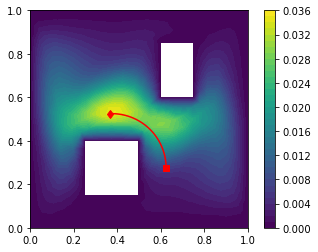

In [7]:
flightpath, grid_t = flight.flightpath, flight.grid_t

fom.plot(state, time=grid_t[-1])
plt.plot(flightpath[:, 0], flightpath[:, 1], color="r")
plt.plot([flightpath[0, 0]], [flightpath[0, 1]], color="r", marker="s")
plt.plot([flightpath[-1, 0]], [flightpath[-1, 1]], color="r", marker="d")

In our baseline code, a measurement along this path takes about half a second. If the same code is run again, it takes about the same time again. Obviously that's not efficient when the discretization is fine and we need to take many measurements several times in the course of the optimization.

In [8]:
# measure data
tStart = time.time()
data = drone.measure(flight=flight, state=state)
print("measurement time (run 1): ", time.time()-tStart, "s.")

tStart = time.time()
data = drone.measure(flight=flight, state=state)
print("measurement time (run 2): ", time.time()-tStart, "s.")

measurement time (run 1):  0.5222461223602295 s.
measurement time (run 2):  0.0018916130065917969 s.


After the first, longer computation, all following measurements for the same flight path should be very fast. More than that, if we evaluate on a flightpath that overlaps with the current one, the evaluation should speed up too:

In [9]:
# user setting: characterize the flight path
alpha = np.array([0.25, 0.05]) # radius, speed

# compute flight for alpha
flight = drone.plan_flight(alpha=alpha)

# measure data
tStart = time.time()
data = drone.measure(flight=flight, state=state)
print("measurement time (run 1): ", time.time()-tStart, "s.")

tStart = time.time()
data = drone.measure(flight=flight, state=state)
print("measurement time (run 2): ", time.time()-tStart, "s.")

measurement time (run 1):  0.007465839385986328 s.
measurement time (run 2):  0.0019409656524658203 s.


The only times when this doesn't happen is when the time discretization is so coarse in comparison to the measurement memory mesh that it needs to compute entries that were previously skipped.

If we extend our path, for instance by flying half a circle instead of a quarter, we only need to compute those additional entries that weren't reached before:

In [10]:
# user setting: characterize the flight path
alpha = np.array([0.25, 0.2]) # radius, speed

# compute flight for alpha
flight = drone.plan_flight(alpha=alpha)

# measure data
tStart = time.time()
data = drone.measure(flight=flight, state=state)
print("measurement time (run 1): ", time.time()-tStart, "s.")

tStart = time.time()
data = drone.measure(flight=flight, state=state)
print("measurement time (run 2): ", time.time()-tStart, "s.")

measurement time (run 1):  0.4171161651611328 s.
measurement time (run 2):  0.0023207664489746094 s.


Of course we are introducing approximation error by evaluating the measurements on the memory mesh. We can disable the memory by setting:

In [11]:
detector.bool_remember_measurements = False

Now the code takes very long again, but does not have the approximation error. Let's see how much difference it makes:

In [12]:
tStart = time.time()
data_exact = drone.measure(flight=flight, state=state)
print("measurement time (run 2): ", time.time()-tStart, "s.")

measurement time (run 2):  0.4805638790130615 s.


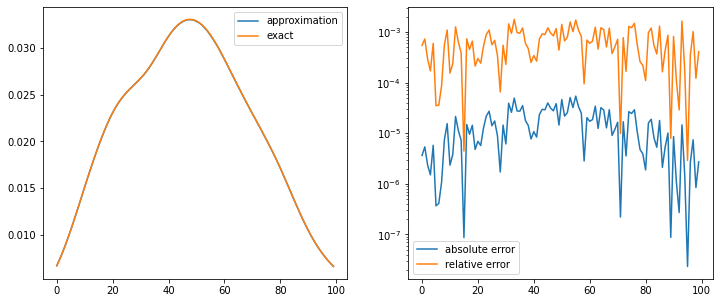

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(data, label = "approximation")
axs[0].plot(data_exact, label="exact")

axs[1].semilogy(np.abs(data-data_exact), label = "absolute error")
axs[1].semilogy(np.abs(data-data_exact)/np.abs(data), label = "relative error")

axs[0].legend()
axs[1].legend()

For our example here (stationary) the error is $\approx 1e-5$, or just under 1%. That's ok I guess. If the error needs to be smaller, we can always refine the discretization in the memory mesh.

## Derivatives

Another advantage of storing measuremnts in memory is that we can
- a) do the same with the derivatives
- b) or use FEniCS to compute the derivatives of the measurements

I have implemented option b, such that the returned derivatives are consistent with the measurements. For option a this wouldn't hold. The downsides are: 
- the FEniCS `grad` method gets called for all nodes, so every time we need to compute the gradient and measurements have changed that's quite a bit computation; 
- since the derivatives are piecewise constant, this can again introduce some difficulty for the optimization - after all, that's the reason why we switched the FOM to non-linear elements;
- for linear FEs I don't think we can expect the gradients to converge in the relative sense. L2 error is fine, but not pointwise, and hence also not the relative error.

All of this means that we cannot arbitrarily trust the gradients of the memory terms. That's ok though, because it is an _approximation_. We can use it to get close enough to the mimimum, and then switch to the trusted but slower gradients and measurement evaluations from there. 

Let's look at option b first and see how much error that introduces.

In [14]:
detector.bool_remember_measurements = False

tStart = time.time()
deriv_exact = drone.d_measurement_d_position(flight=flight, state=state)
print("time to compute derivative: ", time.time()-tStart, "s.")

# reformat to 1d array
deriv_exact = np.hstack([np.diag(deriv_exact[:, :n_steps]), np.diag(deriv_exact[:, n_steps:])])

time to compute derivative:  0.710623025894165 s.


Now we turn the memory back on and compute the derivatives twice:

In [15]:
detector.bool_remember_measurements = True

tStart = time.time()
deriv = drone.d_measurement_d_position(flight=flight, state=state)
print("time to compute derivative: ", time.time()-tStart, "s.")

tStart = time.time()
deriv_2 = drone.d_measurement_d_position(flight=flight, state=state)
print("time to compute derivative: ", time.time()-tStart, "s.")

print("Same derivative was computed both times:", np.isclose(deriv, deriv_2).all())

# reformat to 1d array
deriv = np.hstack([np.diag(deriv[:, :n_steps]), np.diag(deriv[:, n_steps:])])

time to compute derivative:  0.09108304977416992 s.
time to compute derivative:  0.002374887466430664 s.
Same derivative was computed both times: True


Text(0.5, 1.0, 'y direction')

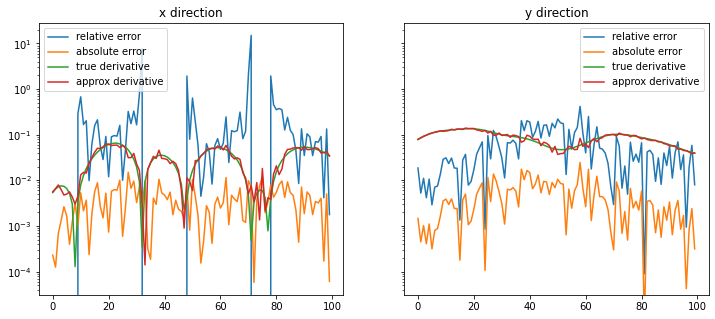

In [16]:
fig, axs = plt.subplots(1, 2, sharey = True, figsize=(12, 5))

axs[0].semilogy((np.abs(deriv-deriv_exact)/deriv_exact)[:n_steps], label = "relative error")
axs[0].semilogy(np.abs(deriv-deriv_exact)[:n_steps], label = "absolute error")
axs[0].semilogy(np.abs(deriv_exact)[:n_steps], label = "true derivative")
axs[0].semilogy(np.abs(deriv)[:n_steps], label = "approx derivative")

axs[0].legend()
axs[0].set_title("x direction")

axs[1].semilogy(np.abs((deriv-deriv_exact)/deriv_exact)[n_steps:], label = "relative error")
axs[1].semilogy(np.abs(deriv-deriv_exact)[n_steps:], label = "absolute error")
axs[1].semilogy(np.abs(deriv_exact)[n_steps:], label = "true derivative")
axs[1].semilogy(np.abs(deriv)[n_steps:], label = "approx derivative")

axs[1].legend()
axs[1].set_title("y direction")

We can see that the absolute error is nice and small for both x and y direction. For the x direction the relative error has some large spikes around areas where the true derivative gets very small. I do not think we can circumvent that, at least not without going into higher order FE methods, which for the approximation bring in their own issues. Since this only happens for small derivatives, the absolute error is small, and to my knowledge the optimization's termination criterion measures the absolute value of the derivative, I don't think this is a big issue. Obviously we can improve the error by choosing a finer mesh size for the memory, but as long as we are using linear FE in the memory the gradient is always going to be piecewise constant. If needed, I can always change the implementation such that the memory works with, say, quadratic FEs, but for now I leave it as is - for the reasons outlined above. To my understanding, given a termination accuracy `eps` for the optimization routine, it's just important to choose `memory_meshDim` large enough that the _absolute_ error falls below this threshold. I mean, that's the same argument as with FE discretization `meshDim`, the time discretization `n_steps`, and the resolutionn `meshDim_drone` used for computing the weighted integral on the truncated domain.

In any case, the convergence plots below should provide some help for choosing `memory_meshDim`.

## Convergence

In [17]:
detector.bool_remember_measurements = False

time_exact = np.zeros(2)

tStart = time.time()
data_exact = drone.measure(flight=flight, state=state)
time_exact[0] = time.time()-tStart

tStart = time.time()
deriv_exact = drone.d_measurement_d_position(flight=flight, state=state)
time_exact[1] = time.time()-tStart

deriv_exact = np.hstack([np.diag(deriv_exact[:, :n_steps]), np.diag(deriv_exact[:, n_steps:])])

In [18]:
n_test = 9

detector.bool_remember_measurements = True

memory_mesh_dimensions = 2**np.arange(1, 1+n_test)
errors = np.zeros((n_test, n_steps))
errors_deriv = np.zeros((n_test, 2*n_steps))
compute_time = np.zeros((2, n_test))

for n in range(n_test):
    print("iteration {}/{}".format(n+1, n_test))
    
    # tell the state about the discretization it should use for its memory terms
    state.setup_measurement_memory(meshDim = memory_mesh_dimensions[n])
    
    # compute measurements
    tStart = time.time()
    data = drone.measure(flight=flight, state=state)
    compute_time[0, n] = time.time()-tStart
    
    # compute derivatives
    tStart = time.time()
    deriv = drone.d_measurement_d_position(flight=flight, state=state)
    compute_time[1, n] = time.time()-tStart
    
    # rescale
    deriv = np.hstack([np.diag(deriv[:, :n_steps]), np.diag(deriv[:, n_steps:])])
    
    # compute errors
    errors[n, :] = np.abs(data-data_exact)
    errors_deriv[n, :] = np.abs(deriv-deriv_exact)

iteration 1/9
iteration 2/9
iteration 3/9
iteration 4/9
iteration 5/9
iteration 6/9
iteration 7/9
iteration 8/9
iteration 9/9


Text(0.5, 0, '1d memory mesh dimension')

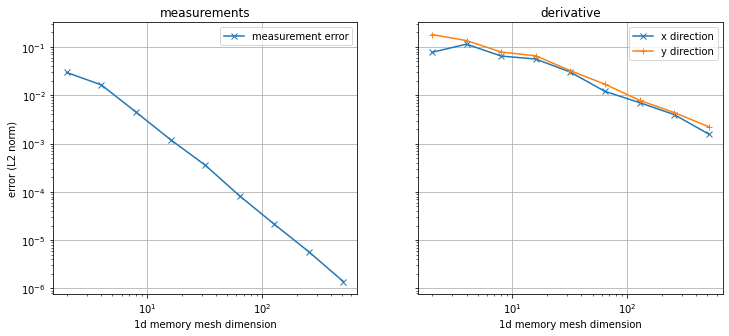

In [19]:
fig, axs = plt.subplots(1, 2, sharey = True, sharex=True, figsize=(12, 5))

axs[0].loglog(memory_mesh_dimensions, np.sqrt(np.diag(inversion.compute_L2norm2(errors.T))), 
              marker="x", label = "measurement error")
axs[1].loglog(memory_mesh_dimensions, np.sqrt(np.diag(inversion.compute_L2norm2(errors_deriv[:, :n_steps].T))), 
              marker="x", label="x direction")
axs[1].loglog(memory_mesh_dimensions, np.sqrt(np.diag(inversion.compute_L2norm2(errors_deriv[:, n_steps:].T))), 
              marker="+", label="y direction")

axs[0].set_title("measurements")
# axs[0].set_xscale("log", base=2)
# axs[0].set_yscale("log", base=2)
axs[0].set_ylabel("error (L2 norm)")
axs[0].grid(True)
axs[0].legend()
axs[0].set_xlabel("1d memory mesh dimension")

axs[1].set_title("derivative")
axs[1].grid(True)
axs[1].legend()
axs[1].set_xlabel("1d memory mesh dimension")

We see that there is a nice convergence in the error (in the L2 norm), both for the measurements and for the derivatives. For larger `memory_meshDim`, these computations do of course take longer because 1) for every new point where we evaluate the measurement we need to compute the measurements for at least 3 nodes, and 2) FEniCS computes the derivatives globally, meaning that even though the memory function is sparse, the derivative computations scale in $\mathcal{O}($ `memory_meshDim` $^2)$. Whether all of this is worth it depends on how often it gets called in the optimization. If you don't like the memory, you can just disable it with:

`detector.bool_remember_measurements = False`

My suggestion is to keep the memory on until some convergence threshold is reached, and then do a couple more iterations with it turned off to get rid of the influence in the approximation error in the optimization.

## The End.

In [20]:
runtime_notebook = time.time()-tStart_notebook
print("Runtime of this notebook: {} min".format(runtime_notebook / 60))

Runtime of this notebook: 0.6202929735183715 min
